# SEN P6: Transfer Learning mit vortrainiertem Modell

Musterlösung zum Praktikumsversuch P6.

## Bibliotheken einbinden

In [1]:
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

import pandas as pd
import matplotlib.pyplot as plt

## Daten laden, begutachten und vorverarbeiten
Hier wird ein Datensatz verwendet, der aus mehreren tausend Bildern verschiedener Blumenarten besteht. Hierzu wird zunächst ein tgz-File mit den Daten aus dem Internet heruntergeladen, entpackt und auf der Festplatte abgelegt.

In [2]:
_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
PATH = tf.keras.utils.get_file('flower_photos', origin=_URL, untar=True)

# Infos: 
# - "flower_photos" ist der Name des Ordners, in dem die heruntergeladenen Bilder abgelegt werden. 
# - untar=True bewirkt, dass die Dateien entpackt werden. 

In [3]:
# Wo liegen die Daten nun?
PATH

'C:\\Users\\kubamatm.HS-KEMPTEN\\.keras\\datasets\\flower_photos'

Nun werden die auf der Festplatte abgelegten Daten eingelesen. Das Einlesen erfolgt in Batches der Größe 32. Außerdem werden die Bilder direkt auf die Abmessungen zugeschnitten, die vom später verwendeten Modell erwartet werden.

In [4]:
# Daten direkt in Batches der Größe 32 einlesen: 
BATCH_SIZE = 32

# Das später zu verwendende vortrainierte Modell erwartet Bilder der Größe 224 x 224 (x 3 Channels), 
# die geladenen Bilder haben unterschiedliche Größen. 
IMG_SIZE = (224, 224)           # Das später verwendete Modell erwartet Bilder der Größe 224 x 224. 

# Trainingsdaten einlesen:
full_dataset = image_dataset_from_directory(PATH,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 3670 files belonging to 5 classes.


In [5]:
# Klassennamen ermitteln und ausgeben (entpsicht den Namen der Ordner auf der Festplatte): 
class_names = full_dataset.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [6]:
# Paar Infos zum Shape der Daten:
for image_batch, labels_batch in full_dataset.take(1):  # take(1) heißt, es soll nur 1 Batch (also 32 Bilder) entnommen werden.
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 224, 224, 3)
(32,)


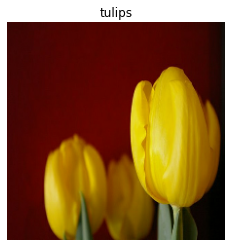

In [7]:
# Darstellen eines beispielhaften Bildes (inkusive Label)
for image_batch, labels_batch in full_dataset.take(1):      
    plt.imshow(image_batch[0].numpy()/255)          # full_dataset ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
    plt.title(class_names[labels_batch[0]]) 
    plt.axis("off")
    
plt.show()

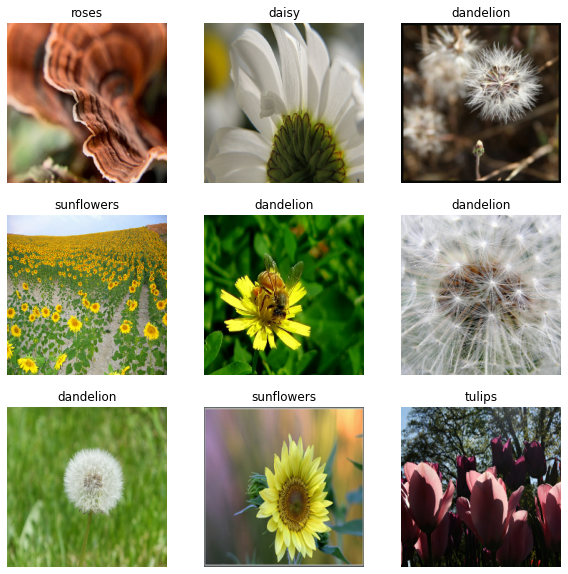

In [8]:
# Darstellen einiger Bilder aus dem Datensatz:
plt.figure(figsize=(10, 10))
for images, labels in full_dataset.take(1):      # take(1) heißt hier: Nimm einen Batch (d.h. 32 Bilder)
    for i in range(9):                           # Aus diesen 32 Bildern die ersten 9 nehmen und darstellen. 
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy()/255)        # train_dataset ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
        plt.title(class_names[labels[i]])        # Korrektes Label über dem Bild darstellen   
        plt.axis("off")
        
plt.show()

<b>Anmerkung:</b> Einige (wenige) Bilder des Flowers-Datensatzes sind Quatsch (weil dort bspw. gar keine Blumen zu sehen sind). Dies wird hier jedoch der Einfachheit halber ignoriert. 

Der geladene Datensatz beinhaltet noch keine Validierungs- und Testdaten. Diese werden daher hier zunänchst aus dem heruntergeladenen Datenbestand entnommen. 

In [9]:
# Wie viele Batches beinhaltet der Datensatz?
print('Anzahl der Batches (vor dem Splitten): %d' % len(full_dataset))

# 20 % der Daten als Val-Daten verwenden:
validation_dataset = full_dataset.take(len(full_dataset) // 5)

# Diese 20 % aus dem full_dataset rauswerfen und das Ganze zum (vorläufigen) Train-Datensatz machen:
train_dataset = full_dataset.skip(len(full_dataset) // 5)

# Aus dem (vorläufigen) Train-Datensatz 10 % (ein Zehntel) für Testdaten verwenden:
len(train_dataset)
test_dataset = train_dataset.take(len(train_dataset) // 10)

# Diese 10 % aus dem train_dataset rauswerfen:
train_dataset = train_dataset.skip(len(train_dataset) // 10)

# Batchgrößen der Datensätze ausgeben: 
print('Anzahl der Train Batches (nach dem Splitten):  %d' % len(train_dataset))
print('Anzahl der Validation Batches (nach dem Splitten): %d' % len(validation_dataset))
print('Anzahl der Test Batches (nach dem Splitten): %d' % len(test_dataset))

Anzahl der Batches (vor dem Splitten): 115
Anzahl der Train Batches (nach dem Splitten):  83
Anzahl der Validation Batches (nach dem Splitten): 23
Anzahl der Test Batches (nach dem Splitten): 9


Zur Klassifikation der Bildinhalte soll später ein vortrainiertes MobileNetV2 Modell umtrainiert und verwendet werden. Dieses Modell kann mit den Bildern, so wie sie aktuell im Datensatz vorliegen, nicht umgehen. Durch Verwendung der speziellen preprocess_input()-Methode werden die Bilder für das Modell vorbereitet. 

Doku zum Modell: https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2

Doku zur Preprocess-Funktion: https://www.tensorflow.org/api_docs/python/tf/keras/applications/mobilenet_v2/preprocess_input

In [10]:
# Preprocessing-Layer des vorhandenen MobileNetV2-Modells verwenden: 
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

## Laden und umtrainieren eines MobileNetV2 Modells
Als Ausgangspunkt für das zu trainierende CNN Modell soll ein vortrainiertes MobileNetV2 Modell (nachfolgend auch als Basismodell bezeichnet) verwendet werden. Dieses wurde mit dem ImageNet Datensatz (= 1,4 Millionen Bilder mit 1000 Klassen) vortrainiert. 

In [11]:
# Zunächst: Shape der Bilder festlegen (224x224 Pixel, 3 Kanäle):
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SIZE)           # (224, 224)
print(IMG_SHAPE)          # (224, 224, 3)

(224, 224)
(224, 224, 3)


<b>Basismodell laden</b>

In [12]:
# Basismodell (= Feature Extractor von MobileNetV2) instanziieren:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=IMG_SHAPE,
                                                            include_top=False,
                                                            weights='imagenet')

In [13]:
# Infos zu den Layern im Basismodell ausgeben: 
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
# Just for Fun: Einen Batch (d.h. 32 Bilder) aus dem Train-Datensatz nehmen und das base_model darauf anwenden
# (um die Shapes der Ausgangsdaten zu sehen):
for image_batch, label_batch in train_dataset.take(1):  # Einen Batch (d.h. 32 Bilder) aus dem Train-Datensatz nehmen.
    feature_batch = base_model(image_batch)             # Das Basismodell auf ein Batch anwenden

print("Image Batch Shape:", image_batch.shape)          # Shape des Input-Batches ansehen
print("Label Batch Shape:", label_batch.shape)          # Shape der Labels in diesem Batch ansehen
print("Feature Batch Shape:", feature_batch.shape)      # Shape des Output-Batches (=Ausgangsdaten des base_model) ansehen.

Image Batch Shape: (32, 224, 224, 3)
Label Batch Shape: (32,)
Feature Batch Shape: (32, 7, 7, 1280)


<b>Fazit</b>: Dieser Feature Extractor wandelt jedes 224x224x3 Bild in ein 7x7x1280 Array.

<b>Basismodell einfrieren</b>

Im nächsten Schritt wird das Basismodell eingefroren und als (nicht trainierbarer) Feature Extractor verwendet. Das eingefrorene Modell wird anschließend um trainierbare Classification Layer erweitert. 

In [15]:
base_model.trainable = False

In [16]:
# Nochmal Infos zu den Layern im Basismodell ausgeben: 
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
__________________________________________________________________________________________________


Wie man sieht sind jetzt (im Gegensatz zu oben, bevor "base_model.trainable = False" gesetzt wurde) alle Parameter im Modell "non-trainable". 

<b>Classification Layer erstellen</b>

Das Modell wird nun um einen GlobalAveragePooling2D Layer ergänzt. Dieser macht aus den Eingangssignalen (7x7x1280 Array) einen Vektor mit 1280 Elementen. 

In [17]:
# GlobalAveragePooling2D-Layer: 
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [18]:
# Just for Fun: Diesen Layer auf ein Batch anwenden, das aus dem base_model rauskommt 
# (um den Shape der Daten zu sehen): 
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Anschließend wird das Modell um einen Dense Layer mit n_classes Neuronen mit Softmax-Aktivierung ergänzt, wobei n_classes die Anzahl der Klassen im Datenbestand darstellt.

In [19]:
# Dense Layer:
n_classes = len(class_names)    # Anzahl der Klassen im Datensatz
prediction_layer = tf.keras.layers.Dense(n_classes, activation="softmax")

In [20]:
# Just for Fun: Diesen Layer auf ein Batch anwenden (um den Shape der Daten zu sehen): 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)   # (32, 5) für 32 Bilder pro Batch und 5 Klassen

(32, 5)


<b>Modell erstellen</b>

Nun wird das Modell erstellt durch Zusammenfügen des Basismodells und der beiden zuletzt erzeugten Classification Layer, hier mittels Keras Functional API. Zusätzlich soll noch ein Dropout-Layer zur Generalisierung eingefügt werden. 

In [21]:
inputs = tf.keras.layers.Input(shape=IMG_SHAPE)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

<b>Modell kompilieren</b>

Da es sich um ein Multiclass-Problem handelt, wird hier als Loss "sparse_categorical_crossentropy" gewählt. Die Lernrate wird zunächst verhältnismäßig groß gewählt. 

In [22]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

In [23]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

<b>Anmerkung</b>: Die rund 2,3 Millionen Parameter des MobileNetV2 Modells sind eingefroren ("non-trainable"). Die rund 6000 Parameter des selbst erstellten Classifiers hingegen sind "trainable". 

<b>Modell trainieren</b>

In [24]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)

Epoch 1/15
83/83 [==============================] - 129s 2s/step - loss: 1.7203 - accuracy: 0.2785 - val_loss: 1.3283 - val_accuracy: 0.4457
Epoch 2/15
83/83 [==============================] - 137s 2s/step - loss: 1.2698 - accuracy: 0.4864 - val_loss: 1.0186 - val_accuracy: 0.6182
Epoch 3/15
83/83 [==============================] - 143s 2s/step - loss: 1.0451 - accuracy: 0.5998 - val_loss: 0.8378 - val_accuracy: 0.7201
Epoch 4/15
83/83 [==============================] - 148s 2s/step - loss: 0.8968 - accuracy: 0.6697 - val_loss: 0.7082 - val_accuracy: 0.7785
Epoch 5/15
83/83 [==============================] - 149s 2s/step - loss: 0.7868 - accuracy: 0.7222 - val_loss: 0.6486 - val_accuracy: 0.7948
Epoch 6/15
83/83 [==============================] - 173s 2s/step - loss: 0.6978 - accuracy: 0.7547 - val_loss: 0.5952 - val_accuracy: 0.8071
Epoch 7/15
83/83 [==============================] - 174s 2s/step - loss: 0.6394 - accuracy: 0.7657 - val_loss: 0.5526 - val_accuracy: 0.8179
Epoch 8/15
83

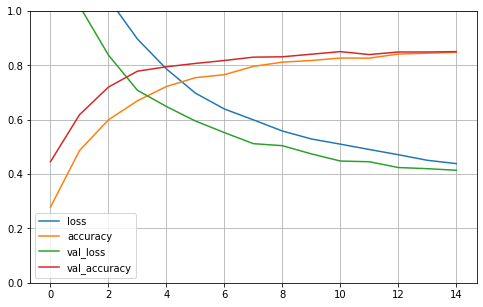

In [25]:
# Lernkurve darstellen:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

<b>Fine tuning</b>

In einem zweiten Trainingsschritt soll nun das Fine Tuning des Modells vorgenommen werden. Hierzu werden einige Upper Layer des Feature Extractors trainierbar gemacht und das Gesamtmodell mit den neuen Daten über einige Epochen trainiert.

Zunächst wird das gesamte Basismodell trainierbar gemacht: 

In [26]:
base_model.trainable = True

In [27]:
# Ermitteln, wie viele Layer das Basismodell aufweist: 
print("Anzahl der Layer im Basismodell:", len(base_model.layers))

Anzahl der Layer im Basismodell: 155


In [28]:
# Das Fine Tuning soll ab Layer 135 stattfinden, die Lower Layer sollen eingefroren werden.
fine_tune_at = 135

# Die unteren 134 Layer einfrieren: 
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [29]:
# Modell erneut kompilieren (jetzt mit deutlich kleinerer Lernrate)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 5)                

In [31]:
# Modell weiter trainieren (Fine Tuning):
history_fine = model.fit(train_dataset,
                         epochs=5,                         
                         validation_data=validation_dataset)

Epoch 1/5
83/83 [==============================] - 162s 2s/step - loss: 0.3788 - accuracy: 0.8673 - val_loss: 0.3174 - val_accuracy: 0.8872
Epoch 2/5
83/83 [==============================] - 161s 2s/step - loss: 0.2948 - accuracy: 0.8968 - val_loss: 0.3006 - val_accuracy: 0.8940
Epoch 3/5
83/83 [==============================] - 203s 2s/step - loss: 0.2570 - accuracy: 0.9082 - val_loss: 0.2934 - val_accuracy: 0.8967
Epoch 4/5
83/83 [==============================] - 215s 3s/step - loss: 0.2203 - accuracy: 0.9229 - val_loss: 0.2632 - val_accuracy: 0.9035
Epoch 5/5
83/83 [==============================] - 219s 3s/step - loss: 0.1948 - accuracy: 0.9327 - val_loss: 0.2611 - val_accuracy: 0.9103


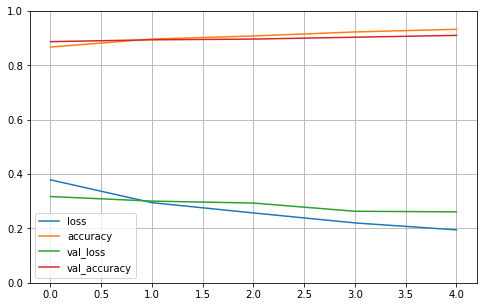

In [32]:
# Lernkurve des Fine Tuning darstellen: 
pd.DataFrame(history_fine.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1) 
plt.show()

<b>Modell evaluieren und anwenden</b>

In [33]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

9/9 [==============================] - 14s 2s/step - loss: 0.2036 - accuracy: 0.9375
Test accuracy : 0.9375


Modell auf ein paar exemplarische Testdaten anwenden: 

In [34]:
for image_batch, label_batch in test_dataset.take(1):   # Einen Batch (d.h. 32 Bilder) aus dem Test-Datensatz nehmen.
    prediction_probas = model.predict(image_batch)      # Predicitions (=Klassenwahrscheinlichkeiten) für alle Bilder in diesem Batch erstellen

In [35]:
# Klassenwahrscheinlichkeiten in tatsächliche Predictions (=Klassen) umrechnen, via Argmax:
predictions = np.argmax(prediction_probas, axis=1)
print("Vorhersagen:    ", predictions)
print("Korrekte Labels:", label_batch.numpy())

Vorhersagen:     [4 3 2 0 3 4 0 4 1 3 4 2 2 4 3 1 1 4 3 1 3 4 0 0 3 4 0 1 0 3 0 1]
Korrekte Labels: [4 3 2 0 3 4 0 4 1 3 4 2 4 4 3 1 1 4 3 1 3 3 0 0 3 4 0 1 0 3 0 1]


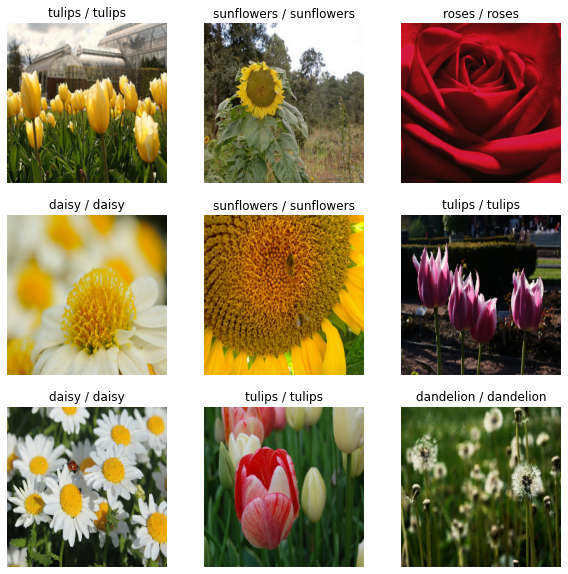

In [36]:
# Das Ganze darstellen (inklusive Labels):
plt.figure(figsize=(10, 10))
for i in range(9):                       # Daher: Aus diesen 32 Bildern die ersten 9 nehmen und darstellen. 
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].numpy()/255)   # full_data ist ein TF-Dataset. Für imshow daher erst in np-Array umwandeln (und auf Pixelwerte zwischen 0 und 1 normieren, statt wie aktuell in full_data zwischen 0 und 255)
    plt.title("%s / %s" % (class_names[predictions[i]], class_names[label_batch[i]]))     # Vorhergesagtes und korrektes Label über dem Bild darstellen   
    plt.axis("off")

plt.show()